# Phase 1
Analysing AML microarray.

## 1. Prepairing Data

### Installing Packages

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

In [ ]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos='http://cran.us.r-project.org')
BiocManager::install()
BiocManager::install("GEOquery")

install.packages("limma")
install.packages("umap")
install.packages("maptools")
install.packages("corrplot")
install.packages("pheatmap")
install.packages("reshape2")
install.packages("mvtnorm")
install.packages("Rtsne")
install.packages("M3C")
install.packages("MASS")
install.packages("ggpubr")
install.packages(c("vegan", "ecodist", "labdsv", "ape", "ade4", "smacof"))
install.packages("fastICA")


### Libraries

In [ ]:
%%R

library(Biobase)
library(GEOquery)
library(limma)
library(umap)
library(maptools)
library(tidyr)
library(dplyr)
library(ggplot2)
library(devtools)
install_github("vqv/ggbiplot")
library(ggbiplot)
library(data.table)
library(corrplot)
library(pheatmap)
library(reshape2)
library(plyr)
library(MASS)
library(mvtnorm)
library(Rtsne)
library("ggpubr")
library(vegan)
library(ecodist)
library(labdsv)
library(ape)
library(ade4)
library(fastICA)
library(smacof)

### Loading Data

In [ ]:
%%R

gds <- getGEO("GSE48558", GSEMatrix = TRUE, AnnotGPL=TRUE)
show(gds)
gds48558 <- gds[[1]]

fvarLabels(gds48558) <- make.names(fvarLabels(gds48558))

# group membership for all samples
gsms <- paste0("1111111111111XXXXXXXXXXXXXXXXXXXXXXXXXXX0XXX0XXXXX",
               "XXXXXXXXXXXXXXXXXX0X0XXX0X0000X0XX00XX00X0X0X0X0X0",
               "XXX0XXX0XXXXXXXXXXXXXXXXXXXXXXXXXXXXX0000000110111",
               "00000000000000000000")
sml <- strsplit(gsms, split="")[[1]]

sel <- which(sml != "X")
sml <- sml[sel]
gds48558 <- gds48558[ ,sel]

gs <- factor(sml)
groups <- make.names(c("Healthy", "AML"))
levels(gs) <- groups
gds48558$group <- gs

$GSE48558_series_matrix.txt.gz
ExpressionSet (storageMode: lockedEnvironment)
assayData: 32321 features, 170 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM1180750 GSM1180751 ... GSM1180919 (170 total)
  varLabels: title geo_accession ... phenotype:ch1 (32 total)
  varMetadata: labelDescription
featureData
  featureNames: 7892501 7892502 ... 8180418 (32321 total)
  fvarLabels: ID Gene title ... GO:Component ID (21 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 23836560 
Annotation: GPL6244 



### Alternative
An alternative way to download data.

In [ ]:
!wget -c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48558/soft/GSE48558_family.soft.gz
!wget -c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48558/miniml/GSE48558_family.xml.tgz
!wget -c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48558/matrix/GSE48558_series_matrix.txt.gz
!wget -c https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE48558&format=file

--2022-12-13 14:06:08--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48558/soft/GSE48558_family.soft.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.229, 130.14.250.13, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49410493 (47M) [application/x-gzip]
Saving to: ‘GSE48558_family.soft.gz’

GSE48558_family.sof 100%[===================>]  47.12M  12.9MB/s    in 4.2s    

2022-12-13 14:06:13 (11.2 MB/s) - ‘GSE48558_family.soft.gz’ saved [49410493/49410493]

--2022-12-13 14:06:13--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48558/miniml/GSE48558_family.xml.tgz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.229, 130.14.250.13, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49166138 (47M)

In [ ]:
%%R
gds858 <- getGEO(filename='GSE48558_series_matrix.txt.gz')

|



### Data Properties

In [ ]:
%%R

expr <- exprs(gds48558)
features <- fData(gds48558)
phenotypes <- pData(gds48558)
dim(gds48558)

Features  Samples 
   32321       67 


In [ ]:
%%R

# Print column names of phenotypes and features
print(colnames(phenotypes))
print(colnames(features))

 [1] "title"                   "geo_accession"          
 [3] "status"                  "submission_date"        
 [5] "last_update_date"        "type"                   
 [7] "channel_count"           "source_name_ch1"        
 [9] "organism_ch1"            "characteristics_ch1"    
[11] "growth_protocol_ch1"     "molecule_ch1"           
[13] "extract_protocol_ch1"    "label_ch1"              
[15] "label_protocol_ch1"      "taxid_ch1"              
[17] "hyb_protocol"            "scan_protocol"          
[19] "description"             "data_processing"        
[21] "platform_id"             "contact_name"           
[23] "contact_email"           "contact_institute"      
[25] "contact_address"         "contact_city"           
[27] "contact_zip/postal_code" "contact_country"        
[29] "supplementary_file"      "data_row_count"         
[31] "relation"                "phenotype:ch1"          
[33] "group"                  
 [1] "ID"                    "Gene.title"            "Gen

### Checking the Quality of Data

#### Normalizing the Data

In [ ]:
%%R
print(min(expr))
print(max(expr))

[1] 1.611473
[1] 13.76154


In [ ]:
%%R

# log2 transform
qx <- as.numeric(quantile(expr, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) || (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { 
    expr[which(expr <= 0)] <- NaN
    expr <- log2(expr) 
}

dim(expr)

[1] 32321    67


#### Differential Expression Analysis

In [ ]:
%%R

design <- model.matrix(~group + 0, gds48558)
colnames(design) <- levels(gs)

fit <- lmFit(gds48558, design)  # fit linear model

# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)

tT <- subset(tT, select=c("Gene.symbol", "Gene.ID","adj.P.Val","logFC"))
write.table(tT, file='AML_Healthy.tsv', row.names=F, sep="\t", quote=F)

head(tT)

        Gene.symbol Gene.ID    adj.P.Val     logFC
8016932         MPO    4353 3.617813e-19 -5.563501
7970737        FLT3    2322 4.835716e-19 -5.250065
7989647    KIAA0101    9768 6.308160e-19 -4.559135
7982663       BUB1B     701 1.664043e-18 -2.756554
8083422      SUCNR1   56670 1.938573e-18 -2.996816
7926259       MCM10   55388 3.712137e-18 -2.318848


In [ ]:
%%R

result <- read.table(file = 'AML_Healthy.tsv', sep = '\t', header = TRUE)
aml.up <- subset(result, logFC > 1 & adj.P.Val < 0.05)
# aml.up.gene <- unique(aml.up$Gene.symbol)
# aml.up.gene <- sub("///.*", "", aml.up.gene)
aml.up.gene <- unique(as.character(strsplit2(aml.up$Gene.symbol, "///")))
write.table(aml.up.gene, file='AML_Healthy_Up.tsv', row.names=F, col.names=F, quote=F)

aml.down <- subset(result, logFC < -1 & adj.P.Val < 0.05)
aml.down.gene <- unique(as.character(strsplit2(aml.down$Gene.symbol, "///")))
write.table(aml.down.gene, file='AML_Healthy_Down.tsv', row.names=F, col.names=F, quote=F)

head(aml.up.gene)

[1] "STK38" "CBX7"  "PLCL2" "PECR"  ""      "HLA-F"


#### Histogram of P-values for all genes

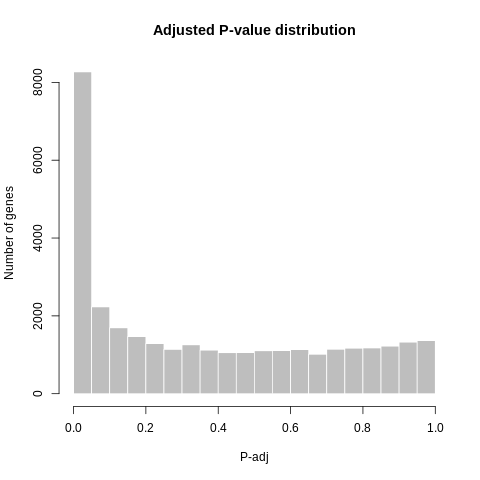

In [ ]:
%%R

tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
     ylab = "Number of genes", main = "Adjusted P-value distribution")

#### Q-Q Plot for t-statistic

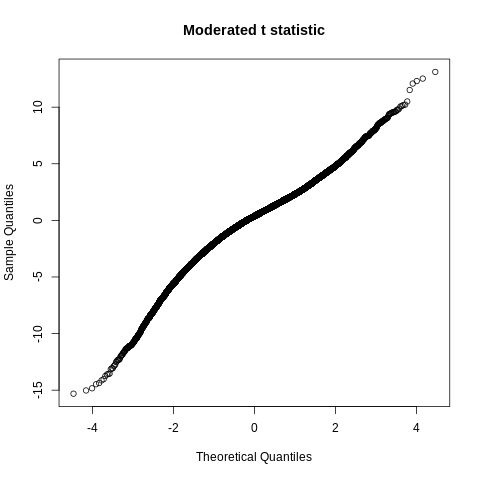

In [ ]:
%%R

t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

#### Volcano Plot (log P-value vs log fold change)

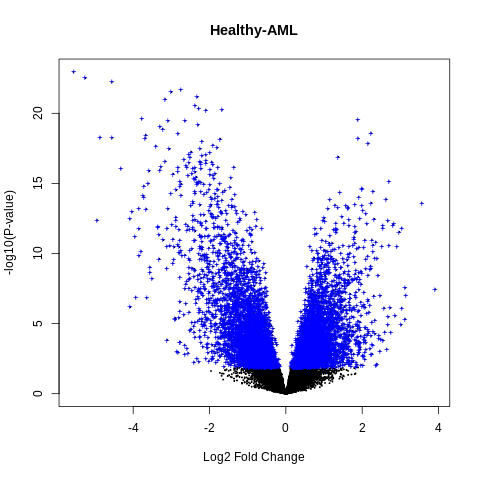

In [ ]:
%%R

# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05)

colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
            highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

#### MD Plot (log fold change vs mean log expression)

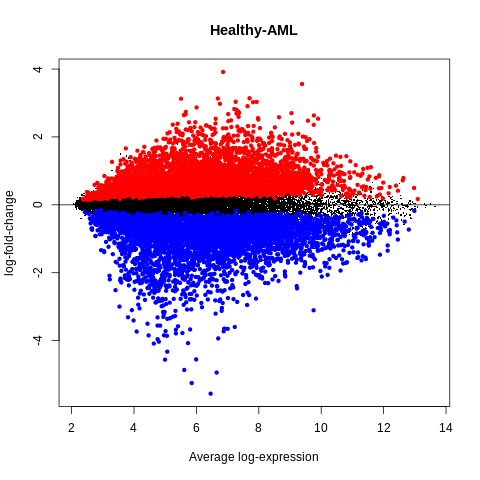

In [ ]:
%%R

# highlight statistically significant (p-adj < 0.05) probes
plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
abline(h=0)

#### Box Plot

In [ ]:
%%R

pdf("boxplot.pdf", width=64)
boxplot(expr)
dev.off()

png 
  2 


### General Expression Data Analysis

#### Expression Value Distribution

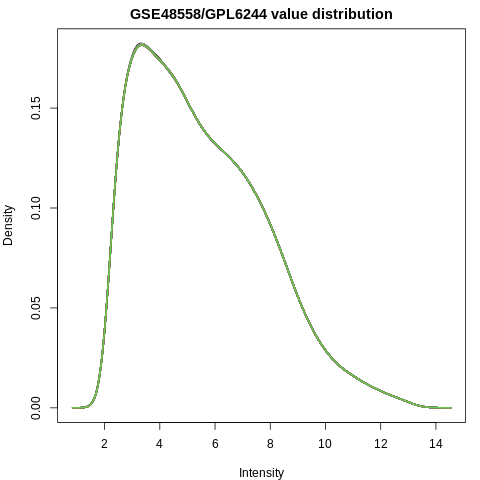

In [ ]:
%%R

par(mar=c(4,4,2,1))
title <- paste("GSE48558", "/", annotation(gds48558), " value distribution", sep ="")
plotDensities(expr, main=title, legend=F)

#### Mean Variance Trend
We eliminate rows with NAs.

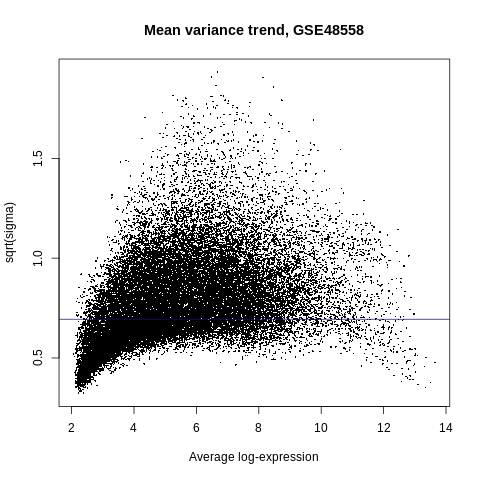

In [ ]:
%%R

expr <- na.omit(expr)
plotSA(fit2, main="Mean variance trend, GSE48558")

#### UMAP Plot (multi-dimensional scaling)
We remove duplicates from data.

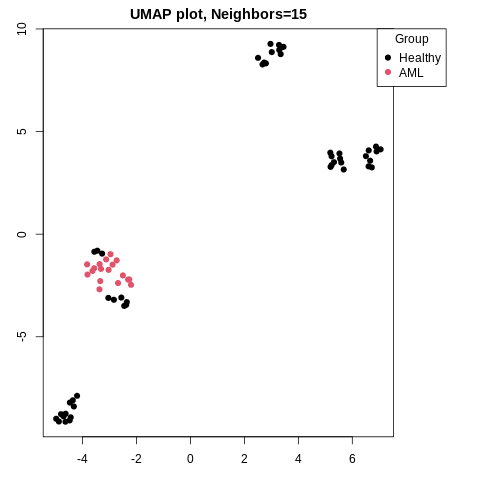

In [ ]:
%%R

expr <- expr[!duplicated(expr), ]  # remove duplicates
ump <- umap(t(expr), n_neighbors = 15, random_state = 123)
par(mar=c(3,3,2,6), xpd=TRUE)
plot(ump$layout, main="UMAP plot, Neighbors=15", xlab="", ylab="", col=gs, pch=20, cex=1.5)
legend("topright", inset=c(-0.15,0), legend=levels(gs), pch=20,
col=1:nlevels(gs), title="Group", pt.cex=1.5)
# pointLabel(ump$layout, labels = rownames(ump$layout), method="SANN", cex=0.6)

## 3. Dimensionality Reduction

### PCA

In [ ]:
# todo
%%R
pca <- prcomp(expr, center=TRUE, scale.=TRUE)
summary(pca)

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     7.6458 1.57065 1.12017 1.00198 0.78282 0.61918 0.52199
Proportion of Variance 0.8725 0.03682 0.01873 0.01498 0.00915 0.00572 0.00407
Cumulative Proportion  0.8725 0.90933 0.92806 0.94304 0.95219 0.95791 0.96198
                          PC8     PC9    PC10    PC11    PC12   PC13    PC14
Standard deviation     0.4404 0.39553 0.37623 0.35232 0.31759 0.3058 0.27909
Proportion of Variance 0.0029 0.00233 0.00211 0.00185 0.00151 0.0014 0.00116
Cumulative Proportion  0.9649 0.96721 0.96932 0.97117 0.97268 0.9741 0.97523
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.27612 0.26947 0.26452 0.25317 0.24683 0.23961 0.23592
Proportion of Variance 0.00114 0.00108 0.00104 0.00096 0.00091 0.00086 0.00083
Cumulative Proportion  0.97637 0.97746 0.97850 0.97946 0.98037 0.98122 0.98205
                          PC22    PC23

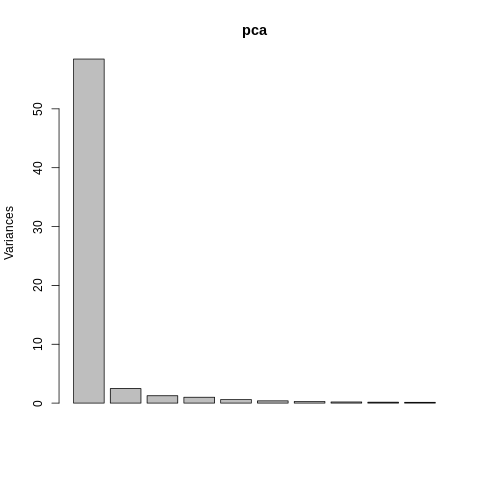

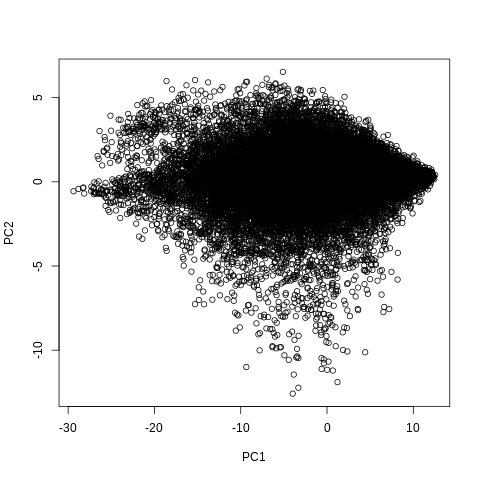

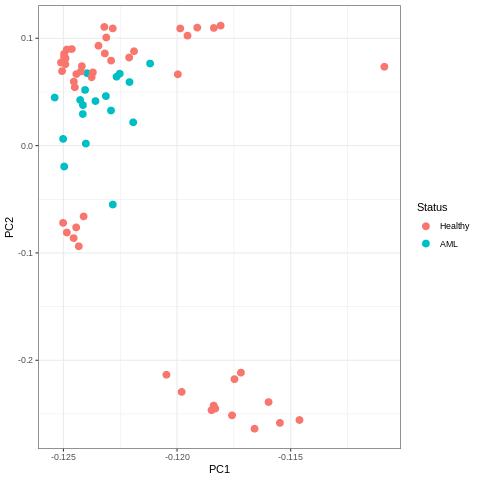

In [ ]:
%%R
plot(pca)
plot(pca$x[, 1:2])
pcar <- data.frame(pca$r[, 1:3], Status = gds48558$group)

ggplot(pcar, aes(PC1, PC2, color = Status)) + geom_point(size = 3) + theme_bw()

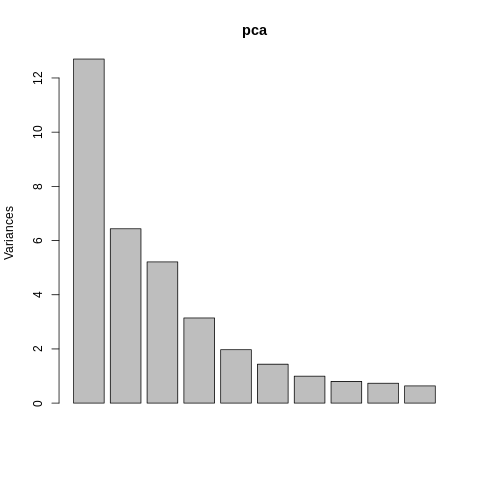

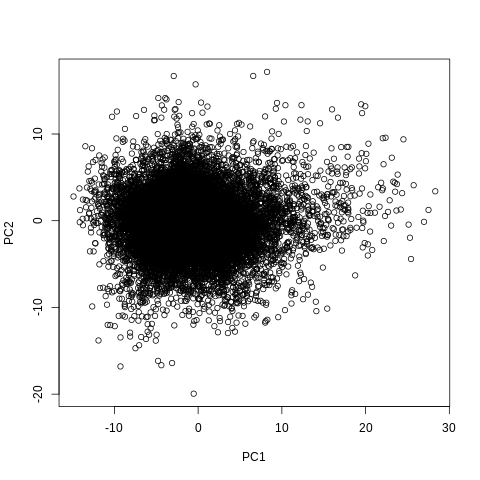

In [ ]:
%%R

expr.scale = t(scale(t(expr), scale = F))
pca <- prcomp(expr.scale)
plot(pca)
plot(pca$x[, 1:2])

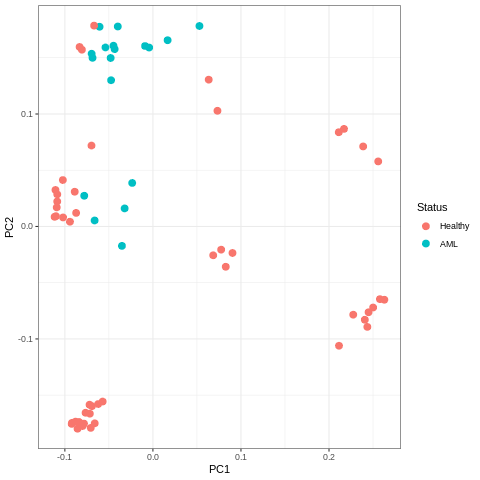

In [ ]:
%%R

pcar <- data.frame(pca$r[, 1:3], Status = gds48558$group)

ggplot(pcar, aes(PC1, PC2, color = Status)) + geom_point(size = 3) + theme_bw()
# ggsave("pca_samples.pdf")

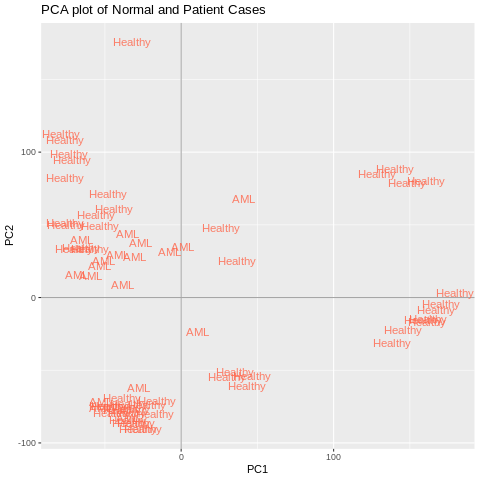

In [ ]:
%%R

# ggbiplot(pca)

scores = as.data.frame(prcomp(t(expr), center=TRUE, scale.=TRUE)$x)

ggplot(data = scores, aes(x = PC1, y = PC2, label = gds48558$group)) +
  geom_hline(yintercept = 0, colour = "gray65") +
  geom_vline(xintercept = 0, colour = "gray65") +
  geom_text(colour = "tomato", alpha = 0.8, size = 4) +
  ggtitle("PCA plot of Normal and Patient Cases")

### TSNE




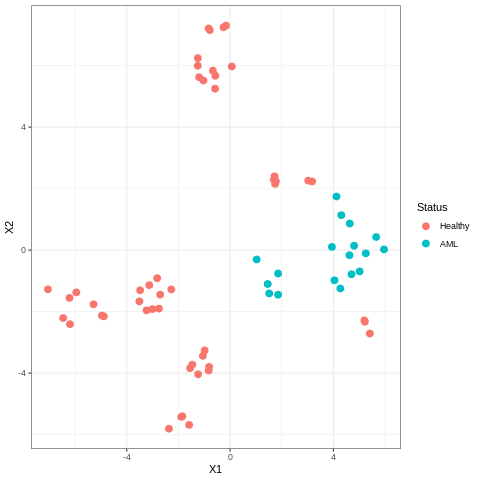

In [ ]:
%%R

set.seed(100)
tsne_results <- Rtsne(t(expr), perplexity=20, check_duplicates = F,dim=2) # You can change the value of perplexity and see how the plot changes

## Generate the t_SNE plot
tcar <- data.frame(tsne_results$Y, Status = gds48558$group)
ggplot(tcar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()

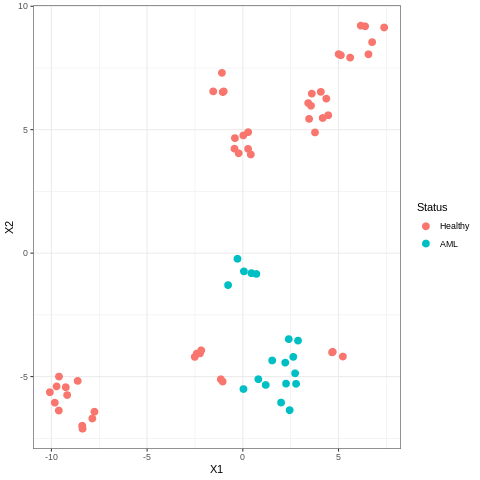

In [ ]:
%%R

set.seed(100)
tsne_results <- Rtsne(t(expr), perplexity=15, check_duplicates = F,dim=2) # You can change the value of perplexity and see how the plot changes

## Generate the t_SNE plot
tcar <- data.frame(tsne_results$Y, Status = gds48558$group)
ggplot(tcar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()

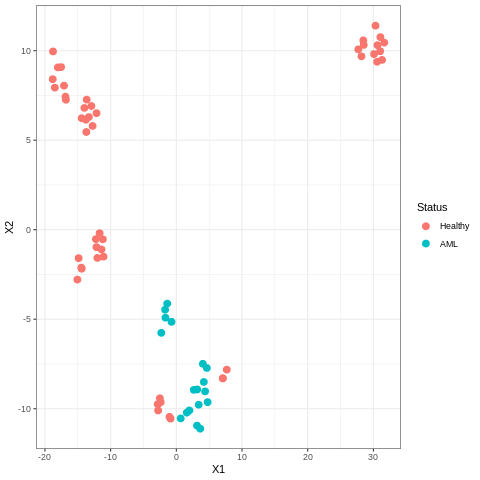

In [ ]:
%%R

set.seed(100)
tsne_results <- Rtsne(t(expr), perplexity=10, check_duplicates = F,dim=2) # You can change the value of perplexity and see how the plot changes

## Generate the t_SNE plot
tcar <- data.frame(tsne_results$Y, Status = gds48558$group)
ggplot(tcar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()

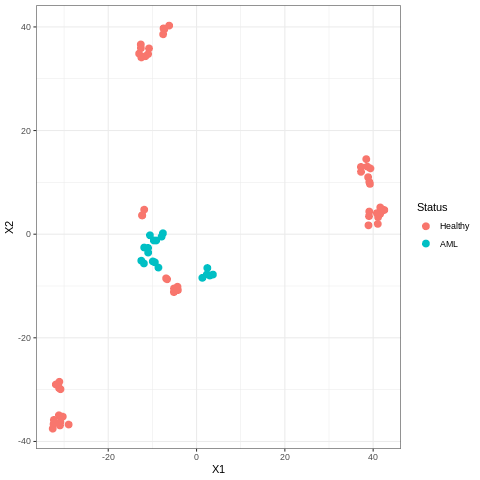

In [ ]:
%%R

set.seed(100)
tsne_results <- Rtsne(t(expr), perplexity=5, check_duplicates = F,dim=2) # You can change the value of perplexity and see how the plot changes

## Generate the t_SNE plot
tcar <- data.frame(tsne_results$Y, Status = gds48558$group)
ggplot(tcar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()

In [ ]:
%%R
summary(tsne_results)

                    Length Class  Mode   
N                     1    -none- numeric
Y                   134    -none- numeric
costs                67    -none- numeric
itercosts            20    -none- numeric
origD                 1    -none- numeric
perplexity            1    -none- numeric
theta                 1    -none- numeric
max_iter              1    -none- numeric
stop_lying_iter       1    -none- numeric
mom_switch_iter       1    -none- numeric
momentum              1    -none- numeric
final_momentum        1    -none- numeric
eta                   1    -none- numeric
exaggeration_factor   1    -none- numeric


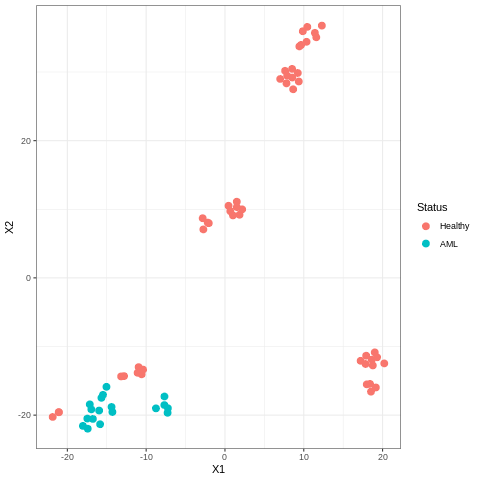

In [ ]:
%%R
expr.scale = t(scale(t(expr), scale = F))
set.seed(100)
tsne_results <- Rtsne(t(expr.scale), perplexity=8, check_duplicates = T,dim=2) # You can change the value of perplexity and see how the plot changes

## Generate the t_SNE plot
tcar <- data.frame(tsne_results$Y, Status = gds48558$group)

ggplot(tcar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()

### MDS


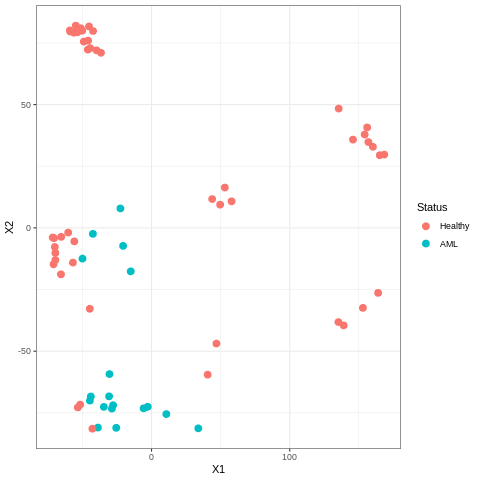

In [ ]:
%%R
expr.scale = t(scale(t(expr), scale = F))
set.seed(100)
fit <- cmdscale(dist(t(expr)), eig = T, k = 2)
x <- fit$points[, 1]
y <- fit$points[, 2]
# mds = mds(delta = t(expr),ndim = 2, type = "ratio" )

## Generate the t_SNE plot
mcar <- data.frame(X1=x,X2=y, Status = gds48558$group)

ggplot(mcar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()



initial  value 29.793213 
final  value 29.789946 
converged


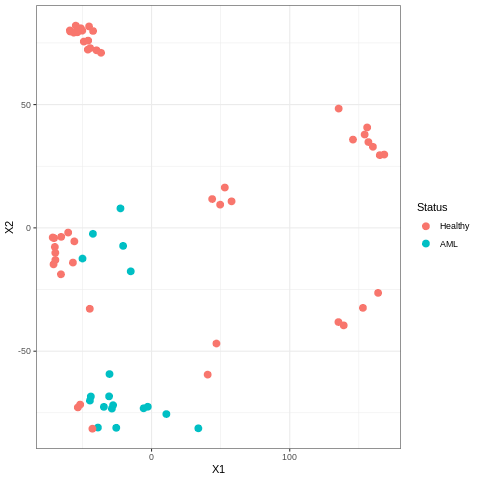

In [ ]:
%%R
fit <- isoMDS(dist(t(expr.scale)), k = 2)
x <- fit$points[, 1]
y <- fit$points[, 2]

## Generate the t_SNE plot
mcar <- data.frame(X1=x,X2=y, Status = gds48558$group)

ggplot(mcar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()



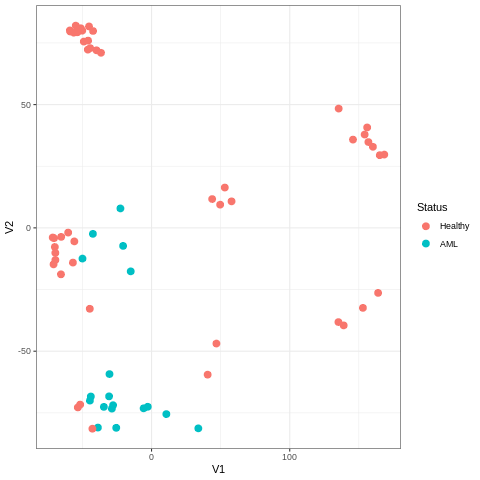

In [ ]:
%%R
set.seed(100)
fit <- data.frame(as.data.frame(wcmdscale(dist(t(expr)), k = 2)),Status = gds48558$group)
# ## Generate the t_SNE plot
ggplot(fit, aes(V1, V2, color = Status)) + geom_point(size = 3) + theme_bw()

Initial stress        : 0.23894
stress after   6 iters: 0.14045


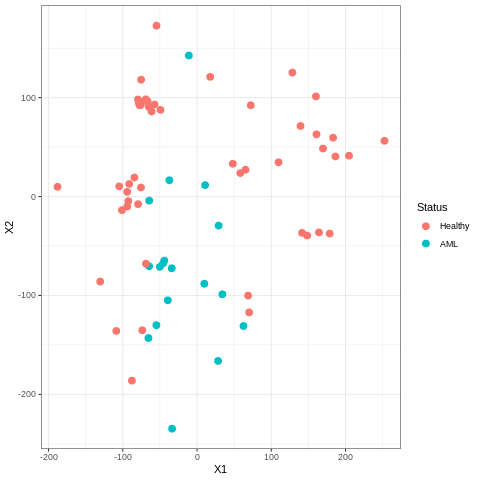

In [ ]:
%%R
set.seed(100)
fit <- sammon(dist(t(expr)), k = 2,niter=100)
x <- fit$points[, 1]
y <- fit$points[, 2]

## Generate the t_SNE plot
mcar <- data.frame(X1=x,X2=y, Status = gds48558$group)
ggplot(mcar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()

##### Principal Coordinates Analysis


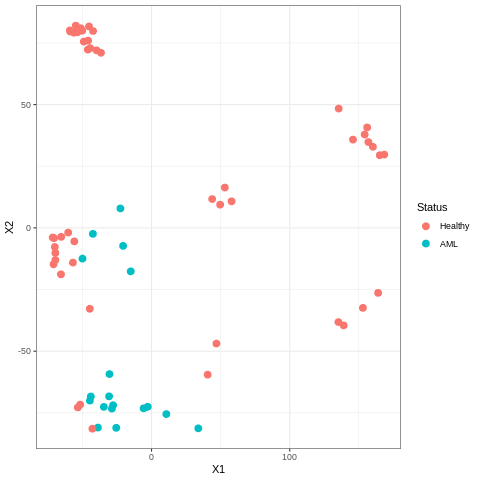

In [ ]:
%%R
pcaa <- pco(dist(t(expr)))
pcacar <- data.frame(X1=pcaa$points[,1],X2=pcaa$points[,2], Status = gds48558$group)
ggplot(pcacar, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()

#### Stress Minimization: SMACOF on symmetric dissimilarity matrix


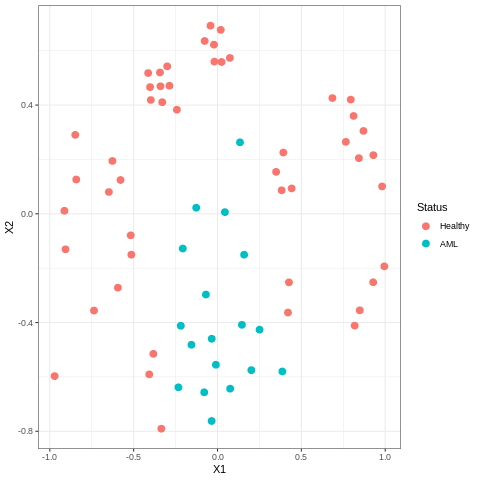

In [ ]:
%%R
SMACOF <- smacofSym(dist(t(expr)),ndim=2)
SMACOF <- data.frame(X1=SMACOF$conf[,1],X2=SMACOF$conf[,2], Status = gds48558$group)
ggplot(SMACOF, aes(X1, X2, color = Status)) + geom_point(size = 3) + theme_bw()

## 4. Correlation

### Correlation between all samples

In [ ]:
%%R

pheatmap(cor(expr), filename="CorHeatmap.pdf", labels_row = status, labels_col = status, width = 16, height = 16, borderColor= NA)

UsageError: Cell magic `%%R` not found.


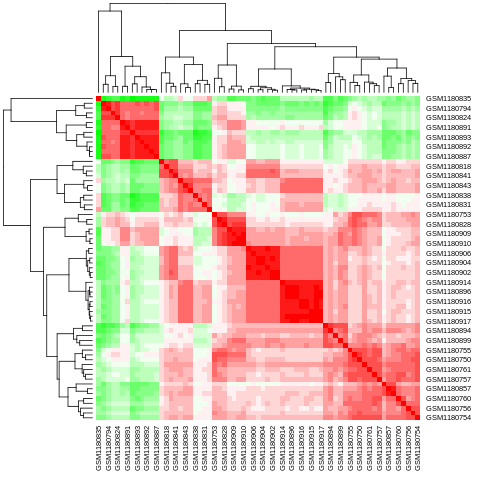

In [ ]:

res <- cor(expr_df)
# corrplot(res)
palette <- colorRampPalette(c("green", "white", "red")) (20)
heatmap(x = res, col=palette, symm=TRUE)

### Correlation by source name

In [ ]:
%%R

data_s <- dplyr::select(phenotypes, geo_accession, "phenotype:ch1", source_name_ch1)
colnames(data_s) <- c("Accession", "Phenotype", "SourceName")
data_s <- data.frame(data_s, Status = gds48558$group)[order(data_s$SourceName),]
data_s

            Accession Phenotype   SourceName  Status
GSM1180750 GSM1180750  Leukemia  AML Patient     AML
GSM1180751 GSM1180751  Leukemia  AML Patient     AML
GSM1180752 GSM1180752  Leukemia  AML Patient     AML
GSM1180753 GSM1180753  Leukemia  AML Patient     AML
GSM1180754 GSM1180754  Leukemia  AML Patient     AML
GSM1180755 GSM1180755  Leukemia  AML Patient     AML
GSM1180756 GSM1180756  Leukemia  AML Patient     AML
GSM1180757 GSM1180757  Leukemia  AML Patient     AML
GSM1180758 GSM1180758  Leukemia  AML Patient     AML
GSM1180759 GSM1180759  Leukemia  AML Patient     AML
GSM1180760 GSM1180760  Leukemia  AML Patient     AML
GSM1180761 GSM1180761  Leukemia  AML Patient     AML
GSM1180762 GSM1180762  Leukemia  AML Patient     AML
GSM1180894 GSM1180894  Leukemia  AML Patient     AML
GSM1180895 GSM1180895  Leukemia  AML Patient     AML
GSM1180897 GSM1180897  Leukemia  AML Patient     AML
GSM1180898 GSM1180898  Leukemia  AML Patient     AML
GSM1180899 GSM1180899  Leukemia  AML Patient  

In [ ]:
%%R

pheatmap(cor(expr), filename='SourceName-Cor-Heatmap.pdf', labels_row = data_s$SourceName, labels_col = data_s$SourceName, width = 16, height = 16, borderColor= NA)